In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Data visualisation
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import optuna
from optuna.samplers import TPESampler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv
/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s4e2/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e2/test.csv")
original = pd.read_csv('/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv')

In [3]:
train.drop(columns = "id",inplace = True)
train.duplicated().sum()

0

In [4]:
test.duplicated().sum()

0

In [4]:
original.drop_duplicates(inplace = True)
original.duplicated().sum()

0

In [5]:
train = pd.concat([original,train],ignore_index=True)

In [6]:
train.duplicated().sum()

0

# Project Introduction
This dataset include data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. THe participants are of ages between 14 and 61 and have diverse eating habits and physical conditions. 

The data was collected using a web platform with a survey where anonymous users answered each question. It contains 17 attributes (including the label of NObeyesdad indicating the obesity level detected) and 20758 records, the records are labeled with the class variable NObeyesdad (Obesity Level), that allows classification/clustering/Regression of the data using the 7 different label categories of Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II and Obesity Type III.


In [8]:
train.shape

(22845, 17)

In [9]:
train.tail()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
22840,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II
22841,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight
22842,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II
22843,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,2.144838,no,0.000000,0.973834,no,Automobile,Overweight_Level_II
22844,Male,26.680376,1.816547,118.134898,yes,yes,3.000000,3.000000,Sometimes,no,2.003563,no,0.684487,0.713823,Sometimes,Public_Transportation,Obesity_Type_II


In [10]:
train.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object


## Variable breakdown
* Gender
* Age
* Height
* Weight
* family_history_with_overweight: Either True or False binary variable.
* FAVC (Frequent consumption of high caloric food): Binary variable that is either True or False
* *FCVC (Frequency of consumption of vegetables)*: Continuous variable on a scale of 1 to 3. Given as floats instead of frequency. Will not be rounded as this seems to have been processed (maybe involving dividing consumption of vegetables over a period of time hence resulting in floats.)
* *NCP (Number of main meals)*: Continuous variable From 1 to 4, although 3 seems the most frequent with the rest being a small proportion of the data. Also given as floats instead of whole number of meals. This will be rounded off to whole numbers to avoid ambiguity.
* __CAEC (Consumption of food between meals)__: Ordinal variable given as sometimes, no, always and frequently. However most of the subjects record a response of "sometimes".
* __SMOKE (smoker or not)__: Binary variable that is either True or False but there are only 200 or so smokers out of the 20k. 
* CH2O (Consumption of water daily): Continuous/ordinal variable on a scale of 1 to 3.
* __SCC (Calories consumption monitoring)__: Binary variable that is either True or False but there are only 700 yes responses out of the 20k.
* FAF (Physical activity frequency): Continuous/ordinal variable on a scale of 1 to 3.
* TUE (Time using technological devices): Continuous/ordinal variable on a scale of 1 to 3.
* *CALC (Consumption of alcohol)*: Ordinal variable given as sometimes, no and frequently although sometimes makes up about 15k of the 20k responses. 
* *MTRANS (Transportation used)*: Ordinal variable given as either walking, public transport or automobile. Public transport makes up about 16k of the 20k total data. Will try to convert into a walking/bike or transport variable, to separate transport activities by basis of sedentary level.



# Exploratory Data Analysis

In [11]:
train.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,22845.000000,22845.000000,22845.000000,22845.000000,22845.000000,22845.000000,22845.000000,22845.000000
mean,23.888513,1.700467,87.793761,2.443675,2.755837,2.027165,0.984585,0.620984
std,5.755338,0.087865,26.363367,0.533392,0.711185,0.608479,0.839728,0.602802
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.631856,66.000000,2.000000,3.000000,1.755907,0.015860,0.000000
50%,22.815416,1.700000,84.000000,2.393837,3.000000,2.000000,1.000000,0.582840
75%,26.000000,1.763029,111.531208,3.000000,3.000000,2.531984,1.600431,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [12]:
train.describe(include = "object")

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
count,22845,22845,22845,22845,22845,22845,22845,22845,22845
unique,2,2,2,4,2,2,4,5,7
top,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_III
freq,11457,18736,20826,19290,22556,22062,16446,18245,4370


### Class Breakdown

The breakdown of classes are mostly balanced, where each class is fairly represented, with the most frequent being obesity type III cases with 4046 and the least frequent being overweight level I with 2427 cases.

In [13]:
train.NObeyesdad.unique()

array(['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
       'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II',
       'Obesity_Type_III'], dtype=object)

In [8]:
order = train.NObeyesdad.unique()[[4,0,1,2,3,5,6]]
order

array(['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I',
       'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II',
       'Obesity_Type_III'], dtype=object)

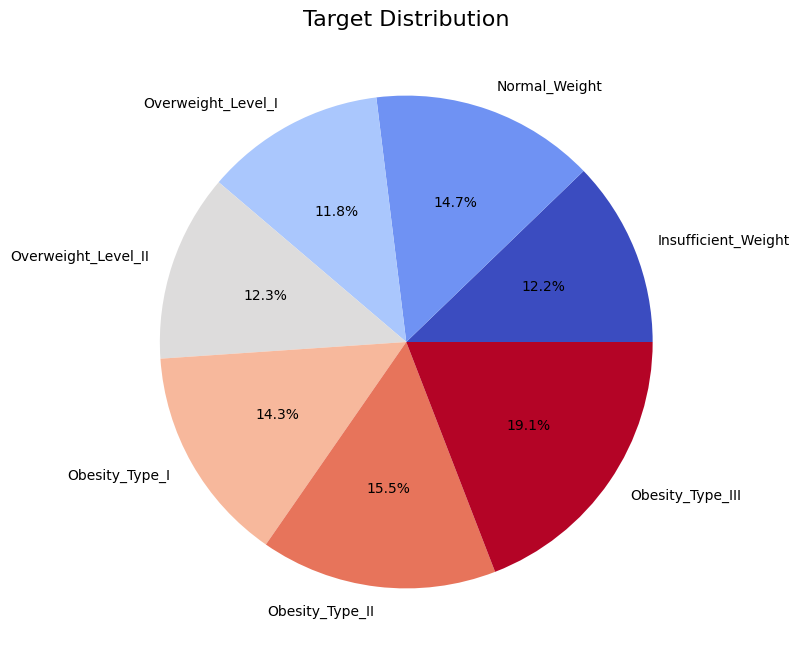

In [9]:
plt.figure(figsize=(8, 8))
colors = plt.cm.coolwarm(np.linspace(0, 1, 7))
class_counts = train.NObeyesdad.value_counts()[order]

plt.pie(class_counts, labels=class_counts.index, autopct="%1.1f%%",
        colors=colors)

plt.title('Target Distribution', fontsize=16)
plt.show()

According to the data card from the original dataset (https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster), NObesity values are:

* Underweight Less than 18.5
* Normal 18.5 to 24.9
* Overweight 25.0 to 29.9
* Obesity I 30.0 to 34.9
* Obesity II 35.0 to 39.9
* Obesity III Higher than 40

Hence, these categorical are actually ordinal in nature with increasing levels of severity of obesity with Insufficient_Weight being touted as the least severe, overweight being the second most severe and obese being the most severe label.

In [10]:
cats=train.select_dtypes(include="object").columns
conts = conts=train.select_dtypes(exclude="object").columns

In [11]:
for col in cats:
    print(col, " ", train[col].unique())

Gender   ['Female' 'Male']
family_history_with_overweight   ['yes' 'no']
FAVC   ['no' 'yes']
CAEC   ['Sometimes' 'Frequently' 'Always' 'no']
SMOKE   ['no' 'yes']
SCC   ['no' 'yes']
CALC   ['no' 'Sometimes' 'Frequently' 'Always']
MTRANS   ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
NObeyesdad   ['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


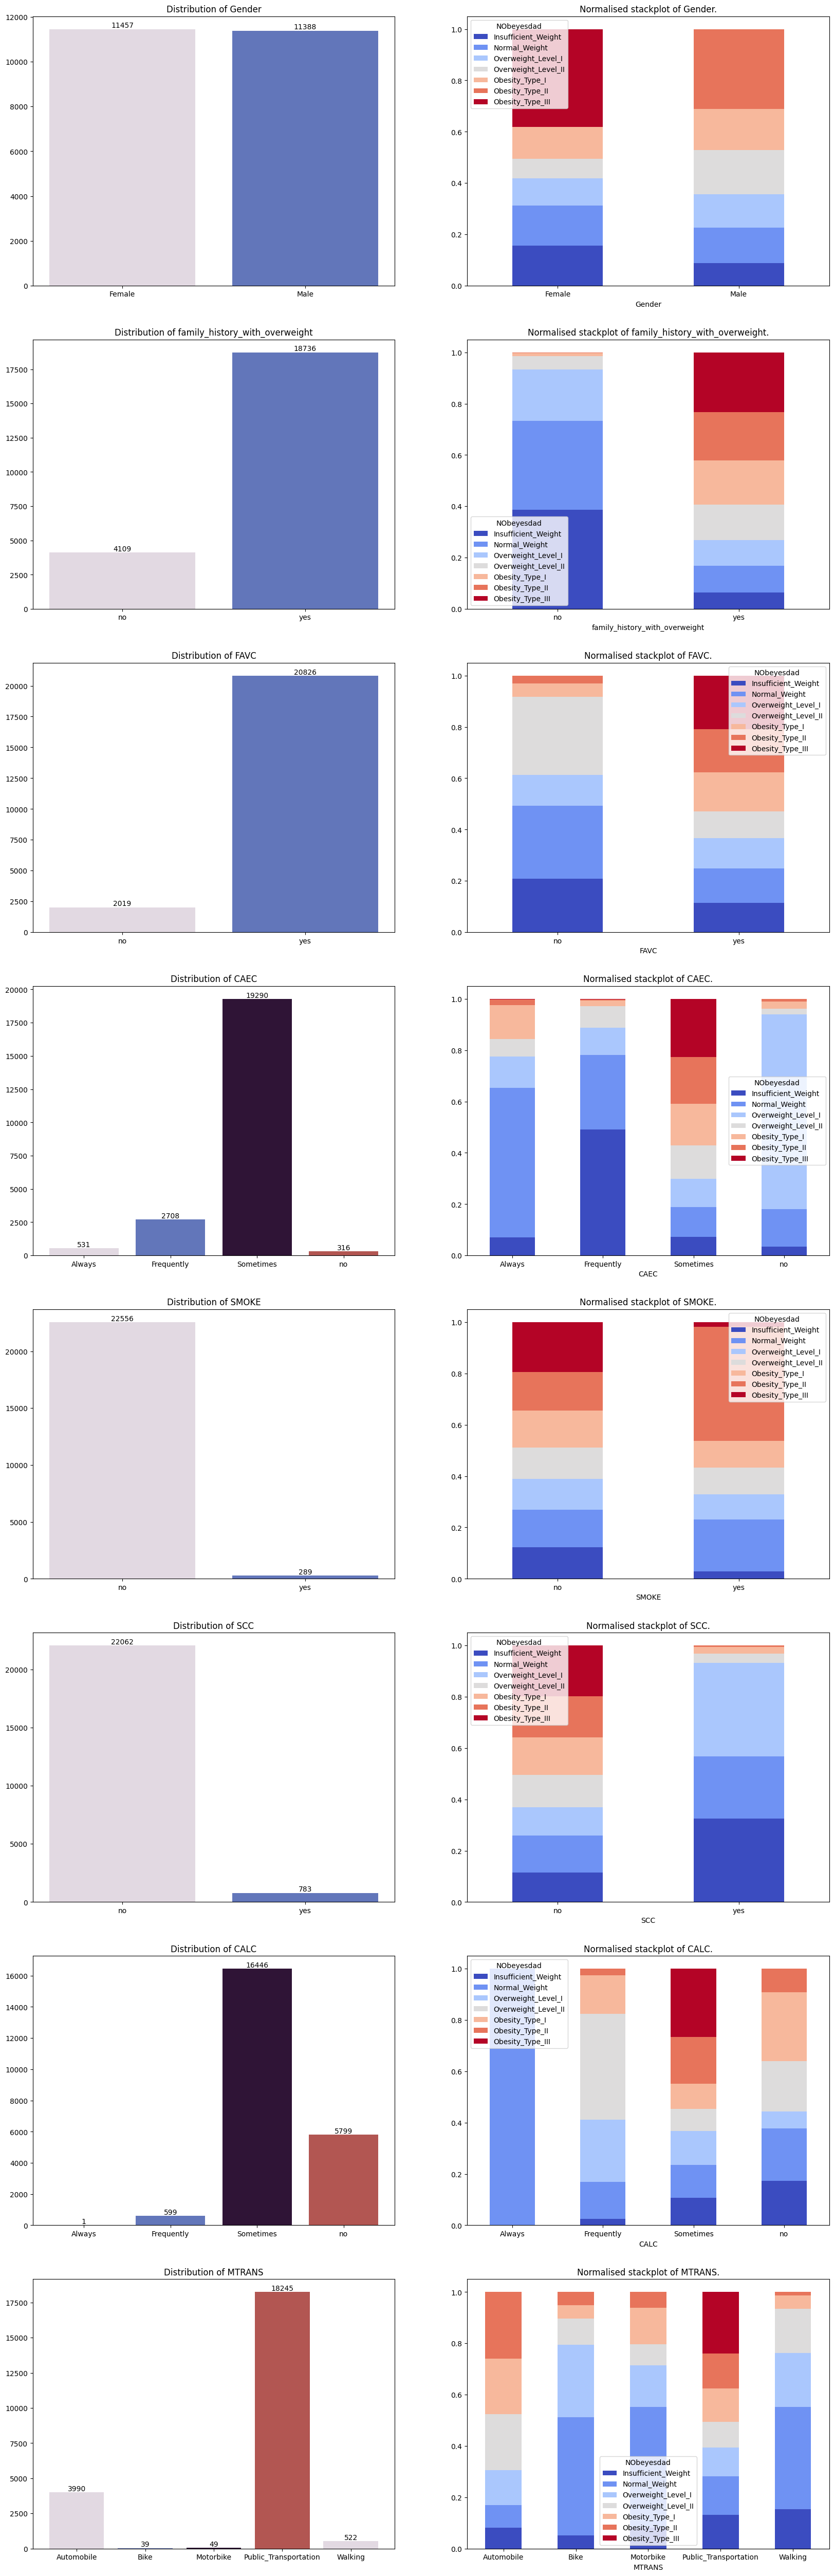

In [18]:
n_cols = 2
n_rows = len(cats[:-1]) # Adjust for desired layout
fig, axs = plt.subplots(nrows=n_rows,ncols = n_cols,figsize=(20, n_rows * 8))
# fig.tight_layout()
target = "NObeyesdad"
# Iterate through columns and plot barplots

for i, col in enumerate(cats[:-1].values):
    p = axs[i,0].bar(height=train[col].value_counts().sort_index().values, 
                x=train[col].value_counts().index.sort_values(),
                    color = plt.cm.twilight(np.linspace(0, 1, 5)))
    axs[i,0].bar_label(p)
    df = train.groupby(col)[target].value_counts(normalize=True).unstack()[order]
    df.plot.bar(stacked=True,color = colors,ax = axs[i,1])
    axs[i,0].set_title(f"Distribution of {col}")
    axs[i,1].set_title(f"Normalised stackplot of {col}.")
    axs[i,1].set_xticklabels(train[col].value_counts().index.sort_values(), rotation=0)
plt.show()

### Gender
There is equal distribution of male and female, however there is notably many females with obesity type III and almost none with obesity type II, while the opposite is true for males.

### Family history of overweight

There is a higher nuber of people with higher levels of obesity among people who have family history of being overweight while those with no family history appear to have no cases of obesity at all, with even very marginal porportion among themsselves even considered overweight.

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Height'}>],
       [<Axes: title={'center': 'Weight'}>,
        <Axes: title={'center': 'FCVC'}>],
       [<Axes: title={'center': 'NCP'}>,
        <Axes: title={'center': 'CH2O'}>],
       [<Axes: title={'center': 'FAF'}>, <Axes: title={'center': 'TUE'}>]],
      dtype=object)

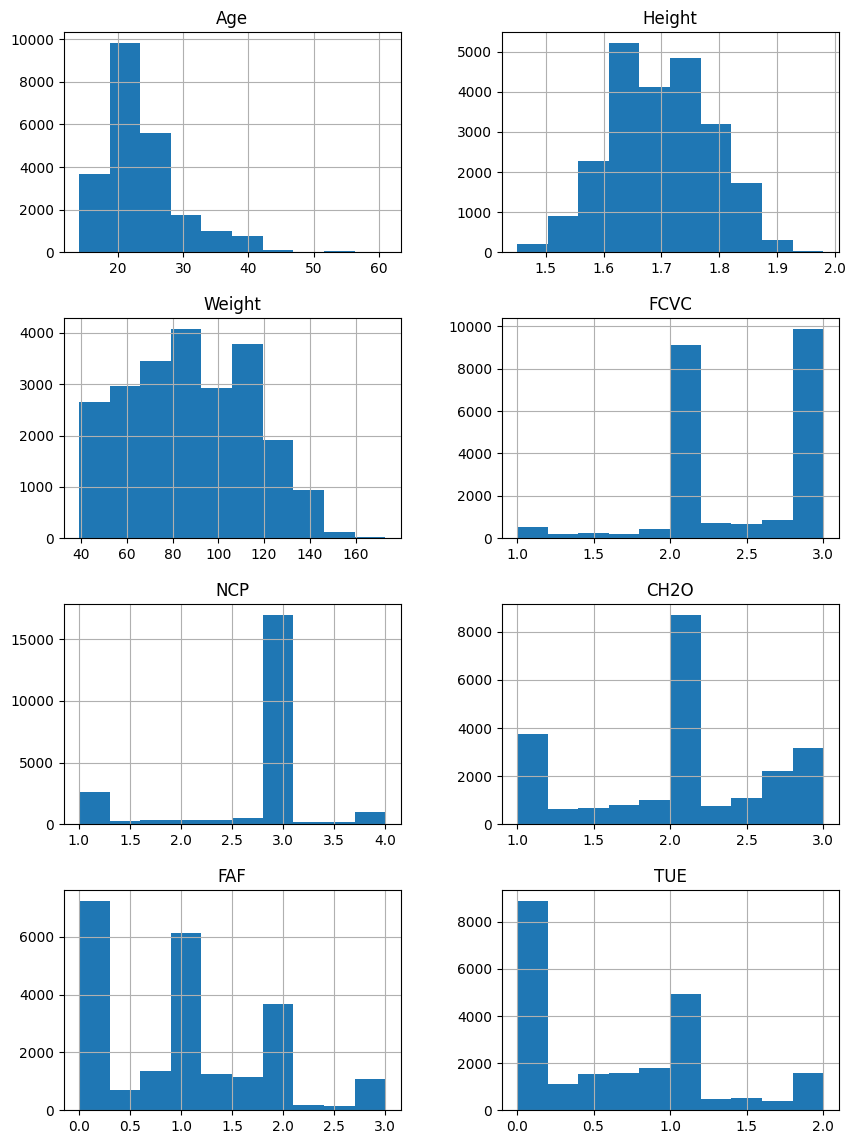

In [19]:
fig, axis = plt.subplots(4, 2,figsize=(10,14))
train[conts].hist(ax = axis)

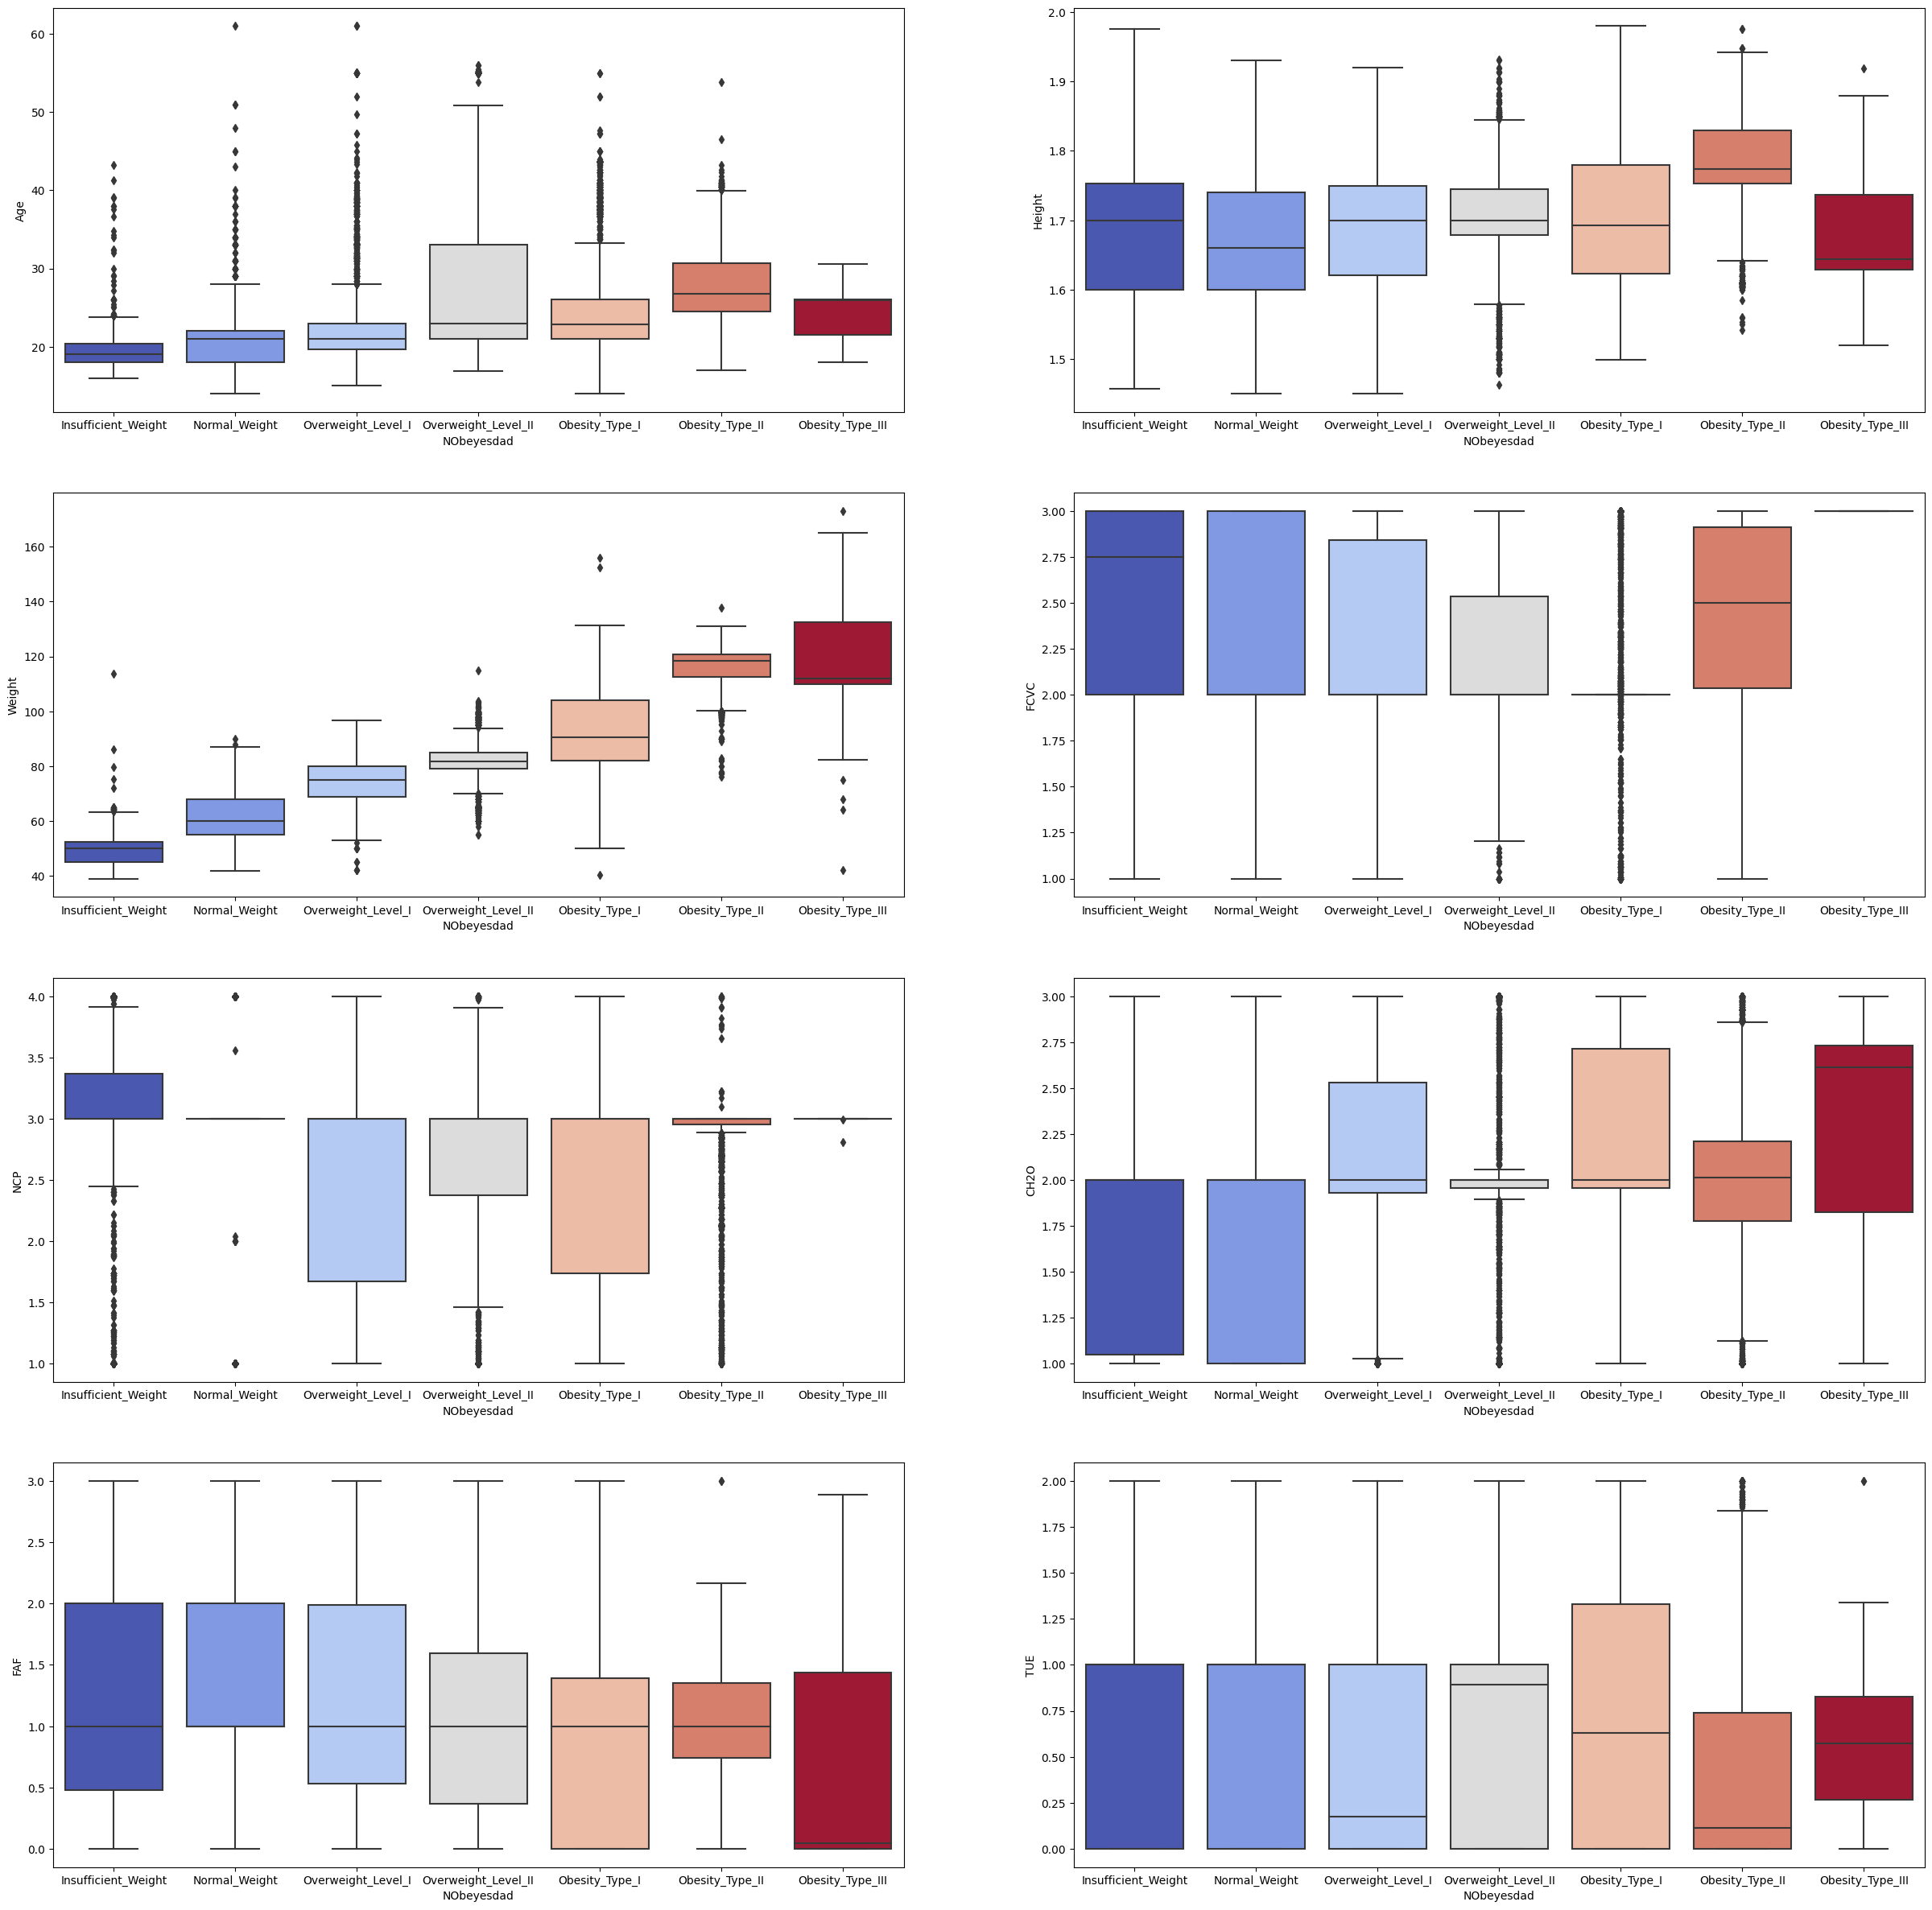

In [20]:
fig, axs = plt.subplots(4, 2, figsize=(30, 30))
axs = axs.flatten()
for var, subplot in zip(conts, axs):
    sns.boxplot(x='NObeyesdad', y=var, data=train, ax=subplot, palette=colors, order = order)

<Axes: >

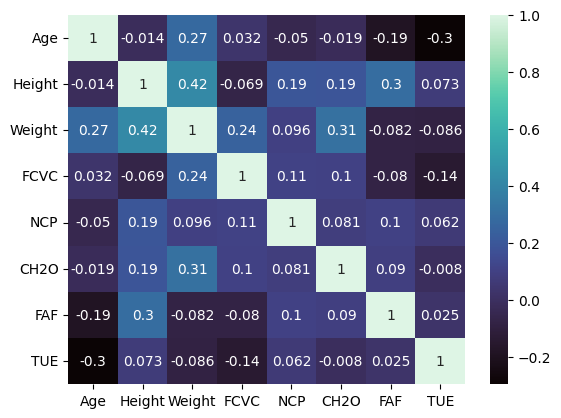

In [21]:
table = train[conts].corr("pearson")
sns.heatmap(table,annot=True,cmap ="mako")

<Axes: xlabel='Height', ylabel='Weight'>

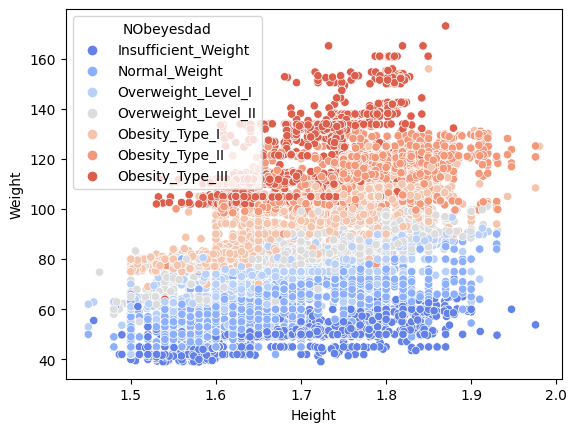

In [22]:
sns.scatterplot(data = train,x = "Height", y = "Weight",hue = "NObeyesdad", hue_order = order, palette = "coolwarm")

In [23]:
train.isna().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [24]:
test.isna().sum()

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
dtype: int64

There are no NA values found in this dataset.

# Preprocessing

In [12]:
train[cats] = train[cats].apply(lambda x: x.astype('category'))

In [61]:
d = {0: 'Insufficient_Weight',
 1: 'Normal_Weight',
 4: 'Obesity_Type_I',
 5: 'Obesity_Type_II',
 6: 'Obesity_Type_III',
 2: 'Overweight_Level_I',
 3: 'Overweight_Level_II'}
d_to = {'Insufficient_Weight':0,
 'Normal_Weight':1,
 'Obesity_Type_I':4,
 'Obesity_Type_II':5,
 'Obesity_Type_III':6,
 'Overweight_Level_I':2,
 'Overweight_Level_II':3}
train.NObeyesdad = train.NObeyesdad.map(d_to)

Mapping the categorical labels into ordinal as per the severity as given from the definitions of the categories.

In [14]:
train["BMI"] = train.Weight/(train.Height)**2

Add a BMI feature calculated from the height and weight.

In [15]:
CAEC = {'no':0,'Sometimes':1,'Frequently':2,'Always':3}
CALC = {'no':0,'Sometimes':1,'Frequently':2,'Always':2}
# MTRANS = {'Public_Transportation':0,'Automobile':1,'Walking':4, "Motorbike":2, "Bike":3}

In [16]:
train.CAEC = train.CAEC.map(CAEC)
train.CALC = train.CALC.map(CALC)
# train.MTRANS = train.MTRANS.map(MTRANS)
train.CAEC = train.CAEC.astype("int8")
train.CALC = train.CALC.astype("int8")

Converting CAEC and CALC frequency categories into ordinal values.

For CALC, "Always" is only found in the test set but not in any of the training set, and is an infrequent occurrence thus it is classfied under "Frequently" as being the closest in meaning.

## Easy peasy features

In [17]:
train.FAVC = train.FAVC.cat.codes
train.SCC = train.SCC.cat.codes
train.SMOKE = train.SMOKE.cat.codes
train.family_history_with_overweight = train.family_history_with_overweight.cat.codes
# train['Physical_Activity_Level'] = train['FAF'] - train['TUE']
# train['Meal_Habits'] = train['FCVC'] * train['NCP']
# train['Healthy_Nutrition_Habits'] = train['FCVC'] / ( 2 * train['FAVC'] - 1)
# train['Tech_Usage_Score'] = train['TUE'] / train['Age']

For FAVC, SCC, Smoke, and Family history of overweight, they are converted into binary variables of 0 and 1. 

The following continuous feature engineered variables were adapted from the notebook of Luca Massaron (https://www.kaggle.com/code/lucamassaron/easy-peasy-eda-xgboost-is-all-you-need)
Some added variables such as Physical Activity Level as a difference between activity frequency and tech usage (time spent sedantary), Meal habits combining the frequency of vegetable consumption with meal frequency in a day, healthy nutrition habits as a product of vegetable consumption frequency and high caloric food consumption and tech usage score as a ratio of age.

In [18]:
train.NCP = train.NCP.round()

In [19]:
train=pd.get_dummies(train,columns=['Gender', 'MTRANS'])

Finally, creating one-hot encoding of the remaining Gender and Method of Transportation with more than one category. 

In [20]:
scale = StandardScaler()

## Train-test Split

In [21]:
conts = conts.append(pd.Index(["BMI","CAEC","CALC"]))

In [22]:
# train.drop(columns = "NObeyesdad").loc[:,(train.drop(columns = "NObeyesdad") > 1).any()].columns

In [23]:
x, y = train.drop(columns = ["NObeyesdad"]), train.NObeyesdad
x[conts] = pd.DataFrame(scale.fit_transform(x[conts]),columns = conts)
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state = 45
                                                   )

In [24]:
x.CALC

0       -1.616550
1        0.476280
2        2.569111
3        2.569111
4        0.476280
           ...   
22840    0.476280
22841    0.476280
22842   -1.616550
22843   -1.616550
22844    0.476280
Name: CALC, Length: 22845, dtype: float64

# Modelling

## XGB

In [25]:
xb = XGBClassifier(random_state=42,device = "cuda")

xb.fit(x_train, y_train)
predictionsx = xb.predict(x_test)
accuracyx = accuracy_score(y_test, predictionsx)
print("Accuracy:", accuracyx)
# predictionsx[0,:]

Accuracy: 0.9115780258262202


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:44:28] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Default
* Accuracy: 0.9070327552986512

After first round of data preprocessing, rounded off NCP, convert CAEC, CALC, MTRANS to ordinal label encodings, 
* Accuracy: 0.9079961464354528

Removing weight, height, adding BMI, and removing rounding of NCP:
* Accuracy: 0.890655105973025

Adding BMI, and removing rounding of NCP:
* Accuracy: 0.9072736030828517

Adding BMI, and removing rounding of NCP, using categories for MTRANS:
* Accuracy: 0.9077552986512524

Adding BMI, rounded off NCP, using categories for MTRANS:
* Accuracy: 0.9089595375722543

Added easy peasy features (without tech usage score):
* Accuracy: 0.9067919075144508

With tech usage score:
* Accuracy: 0.911849710982659

With physical activity level:
* Accuracy: 0.9072736030828517

In [47]:
def objective(trial):
    kfold = StratifiedKFold(5, shuffle=True, random_state=42)
    params = {
        'grow_policy': trial.suggest_categorical('grow_policy', ["depthwise", "lossguide"]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'gamma' : trial.suggest_float('gamma', 1e-9, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.25, 1.0),
        'max_depth': trial.suggest_int('max_depth', 0, 24),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
    }
    
    xgbopt = XGBClassifier(**params,booster='gbtree',random_state=42,device = "cuda", objective = 'multi:softmax',tree_method="hist")
    cv_splits = kfold.split(x, y=y)

    cv = cross_val_score(xgbopt, x, y, cv = cv_splits,scoring='accuracy').mean()
    return cv
sqlite_db = "sqlite:///sqlite.db"
study_name = "multi_class_prediction_of_obesity_risk_xgb"
study_xb = optuna.create_study(storage=sqlite_db, study_name=study_name, 
                            sampler=TPESampler(n_startup_trials=100, multivariate=True, seed=0),
                            direction="maximize", load_if_exists=True)

study_xb.optimize(objective, n_trials=100)

/opt/conda/lib/python3.10/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-02-11 01:25:01,756] A new study created in RDB with name: multi_class_prediction_of_obesity_risk_xgb
[W 2024-02-11 01:25:10,318] Trial 0 failed with parameters: {'grow_policy': 'lossguide', 'n_estimators': 1245, 'learning_rate': 0.5494343511669278, 'gamma': 0.42365479991524996, 'subsample': 0.7344205847999921, 'colsample_bytree': 0.5781904084470194, 'max_depth': 22, 'min_child_weight': 29, 'reg_lambda': 6.82991326137767e-06, 'reg_alpha': 0.08265143168905273} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_34/3971365547.py", line 19, in objective
    cv = cross_val_score(xgbopt, x, 

KeyboardInterrupt: 

In [26]:
# best_cls_params = study_xb.best_params
best_cls_params ={'grow_policy': 'depthwise',
 'n_estimators': 664,
 'learning_rate': 0.10803402535821882,
 'gamma': 0.15992168854801506,
 'subsample': 0.9842202781408137,
 'colsample_bytree': 0.2598677309690449,
 'max_depth': 23,
 'min_child_weight': 22,
 'reg_lambda': 1.4425056211896305e-06,
 'reg_alpha': 0.42870984146285873}
best_cls_params

{'grow_policy': 'depthwise',
 'n_estimators': 664,
 'learning_rate': 0.10803402535821882,
 'gamma': 0.15992168854801506,
 'subsample': 0.9842202781408137,
 'colsample_bytree': 0.2598677309690449,
 'max_depth': 23,
 'min_child_weight': 22,
 'reg_lambda': 1.4425056211896305e-06,
 'reg_alpha': 0.42870984146285873}

{'grow_policy': 'depthwise',
 'n_estimators': 664,
 'learning_rate': 0.10803402535821882,
 'gamma': 0.15992168854801506,
 'subsample': 0.9842202781408137,
 'colsample_bytree': 0.2598677309690449,
 'max_depth': 23,
 'min_child_weight': 22,
 'reg_lambda': 1.4425056211896305e-06,
 'reg_alpha': 0.42870984146285873}

In [27]:
xb = XGBClassifier(**best_cls_params,booster='gbtree',random_state=42,device = "cuda", objective = 'multi:softmax',tree_method="hist")

## LGB

In [ ]:
gb = LGBMClassifier(random_state = 42,device="gpu",verbose=-1)

gb.fit(x_train, y_train)
predictions = gb.predict(x_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy", accuracy)

Default
* Accuracy: 0.9063102119460501

After first round of data preprocessing, rounded off NCP, convert CAEC, CALC, MTRANS to ordinal label encodings, 
* Accuracy 0.9060693641618497

In [ ]:
import os
os.remove("sqlite.db")

In [ ]:
def objective_lgb(trial):
    kfold = StratifiedKFold(5, shuffle=True, random_state=42)
    max_depth = trial.suggest_int('max_depth', 4, 10)
    n_estimators = trial.suggest_int('n_estimators', 500, 2000)
    gamma = trial.suggest_float('gamma', 0, 1)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_float('subsample', 0, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0, 1)
    learning_rate = trial.suggest_float('learning_rate', 0, 1)
    params = {'learning_rate': learning_rate,
              'n_estimators': n_estimators,
              'max_depth': max_depth,
              'lambda_l1': reg_alpha,
              'lambda_l2': reg_lambda,
              'colsample_bytree': colsample_bytree, 
              'subsample': subsample,    
              'min_child_samples': min_child_weight,
              'class_weight': 'balanced'}
    
    lgbopt = LGBMClassifier(**params,objective = "multiclass",
                            num_class = len(y.unique()),
                            boosting_type = "gbdt",
                            metric = "multi_logloss",
                            boost_from_average = True,
                            random_state = 42,
                            device="gpu",
                            verbose=-1)
    cv_splits = kfold.split(x, y=y)

    cv = cross_val_score(lgbopt, x, y, cv = cv_splits,scoring='accuracy').mean()
    return cv

sqlite_db = "sqlite:///sqlite.db"
study_name_lgb = "multi_class_prediction_of_obesity_risk_lgb"
study_lgb = optuna.create_study(storage=sqlite_db, study_name=study_name_lgb, 
                            sampler=TPESampler(n_startup_trials=100, multivariate=True, seed=0),
                            direction="maximize", load_if_exists=True)

study_lgb.optimize(objective_lgb, n_trials=100)

In [28]:
# best_lgb_params = study_lgb.best_params
best_lgb_params = {'max_depth': 4,
 'n_estimators': 800,
 'gamma': 0.01852179446061397,
 'reg_alpha': 0.7936977033574206,
 'reg_lambda': 0.22392468806038013,
 'min_child_weight': 3,
 'subsample': 0.9280812934655909,
 'colsample_bytree': 0.7044144019235328,
 'learning_rate': 0.03183892953130785}
best_lgb_params

{'max_depth': 4,
 'n_estimators': 800,
 'gamma': 0.01852179446061397,
 'reg_alpha': 0.7936977033574206,
 'reg_lambda': 0.22392468806038013,
 'min_child_weight': 3,
 'subsample': 0.9280812934655909,
 'colsample_bytree': 0.7044144019235328,
 'learning_rate': 0.03183892953130785}

{'max_depth': 4,
 'n_estimators': 800,
 'gamma': 0.01852179446061397,
 'reg_alpha': 0.7936977033574206,
 'reg_lambda': 0.22392468806038013,
 'min_child_weight': 3,
 'subsample': 0.9280812934655909,
 'colsample_bytree': 0.7044144019235328,
 'learning_rate': 0.03183892953130785}

In [29]:
lgb = LGBMClassifier(**best_lgb_params,objective = "multiclass",
                            num_class = len(y.unique()),
                            boosting_type = "gbdt",
                            metric = "multi_logloss",
                            boost_from_average = True,
                            random_state = 42,
                            device="gpu",
                            verbose=-1)

## CatBoost

In [69]:
CBC=CatBoostClassifier(random_state = 42, verbose = 0,task_type="GPU",
                           devices='0:1')
CBC.fit(x_train,y_train)
predictions = CBC.predict(x_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy", accuracy)

Accuracy 0.9098270956445612


In [101]:
def objective_cbc(trial):
    kfold = StratifiedKFold(5, shuffle=True, random_state=42)
    params = {'iterations': trial.suggest_int('iterations', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.01, 10.0),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255)
             }
    
    cbcopt = CatBoostClassifier(**params,random_state = 42,verbose = 0,task_type="GPU",devices = "0"
                           )
    cv_splits = kfold.split(x, y=y)
    cv = cross_val_score(cbcopt, x, y, cv = cv_splits,scoring='accuracy').mean()
    return cv

sqlite_db = "sqlite:///sqlite.db"
study_name_cbc = "multi_class_prediction_of_obesity_risk_cbc"
study_cbc = optuna.create_study(storage=sqlite_db, study_name=study_name_cbc, 
                            sampler=TPESampler(n_startup_trials=200, multivariate=True, seed=0),
                            direction="maximize", load_if_exists=True)

study_cbc.optimize(objective_cbc, n_trials=200)

/opt/conda/lib/python3.10/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-02-13 07:18:56,197] Using an existing study with name 'multi_class_prediction_of_obesity_risk_cbc' instead of creating a new one.
[I 2024-02-13 07:20:04,635] Trial 64 finished with value: 0.905668636463121 and parameters: {'iterations': 1143, 'learning_rate': 0.21740491624800165, 'depth': 8, 'l2_leaf_reg': 5.449286946785972, 'bagging_temperature': 4.242311445395658, 'random_strength': 6.459295236553495, 'border_count': 130}. Best is trial 59 with value: 0.9120595316261764.
[I 2024-02-13 07:20:58,445] Trial 65 finished with value: 0.9071131538629897 and parameters: {'iterations': 1795, 'learning_rate': 0.2894622005452985, 'depth': 6, 'l2_leaf_reg': 7.917458655788564, 'bagging_temperature': 5.293660248331515, 'random_strength': 5.680877566378229, 'border_count': 239}. Best is 

In [102]:
best_cbc_params = study_cbc.best_params
# best_cbc_params = 
best_cbc_params

{'iterations': 1294,
 'learning_rate': 0.13414928608861815,
 'depth': 4,
 'l2_leaf_reg': 8.885902373856046,
 'bagging_temperature': 0.6027922629963791,
 'random_strength': 9.964054615103576,
 'border_count': 235}

{'iterations': 578, 'learning_rate': 0.0741366654503643, 'depth': 5, 'l2_leaf_reg': 1.3114212569213621, 'bagging_temperature': 0.13024186674756616, 'random_strength': 1.155727487090342, 'border_count': 170}

In [103]:
CBC = CatBoostClassifier(**best_cbc_params,random_state = 42,verbose = 0,task_type="GPU",devices = "0"
                           )
# CBC.fit(x, y)

# Test Data

### Preprocessing Test Data

In [30]:
test[cats[:-1]] = test[cats[:-1]].apply(lambda x: x.astype('category'))

In [31]:
test["BMI"] = test.Weight/(test.Height)**2

In [32]:
test.CAEC = test.CAEC.map(CAEC)
test.CALC = test.CALC.map(CALC)
# train.MTRANS = train.MTRANS.map(MTRANS)
test.CAEC = test.CAEC.astype("int8")
test.CALC = test.CALC.astype("int8")

In [33]:
test.FAVC = test.FAVC.cat.codes
test.SCC = test.SCC.cat.codes
test.SMOKE = test.SMOKE.cat.codes
test.family_history_with_overweight = test.family_history_with_overweight.cat.codes
# test['Physical_Activity_Level'] = test['FAF'] - test['TUE']
# test['Meal_Habits'] = test['FCVC'] * test['NCP']
# test['Healthy_Nutrition_Habits'] = test['FCVC'] / ( 2 * test['FAVC'] - 1)
# test['Tech_Usage_Score'] = test['TUE'] / test['Age']

In [34]:
test.NCP = test.NCP.round()

In [35]:
test=pd.get_dummies(test,columns=['Gender', 'MTRANS'])

In [36]:
ids = pd.DataFrame(test.id)
test = test.drop(columns = ["id"])

In [37]:
test[conts] = pd.DataFrame(scale.transform(test[conts]),columns = conts)

### Cross Validation Ensembling 

In [104]:
oof_list, predict_list = pd.DataFrame(), pd.DataFrame()

In [39]:
def cross_val_model(estimators, verbose = True):
    skf = StratifiedKFold(5, shuffle=True, random_state=42)
    test_predictions = np.zeros((len(test),7))
    valid_predictions = np.zeros((len(x),7))

    val_scores, train_scores = [],[]
    for fold, (train_ind, valid_ind) in enumerate(skf.split(x,y)):
        model = estimators
        #define train set
        X_train = x.iloc[train_ind]
        y_train = y.iloc[train_ind]
        #define valid set
        X_valid = x.iloc[valid_ind]
        y_valid = y.iloc[valid_ind]

        model.fit(X_train, y_train)
        if verbose:
            print(f"Fold: {fold+1}")
            print(f"Train Accuracy Score: {accuracy_score(y_true=y_train,y_pred=model.predict(X_train))}")
            print(f"Valid Accuracy Score: {accuracy_score(y_true=y_valid,y_pred=model.predict(X_valid))}")
            print("")

        
        test_predictions += model.predict_proba(test)/skf.get_n_splits()
        valid_predictions[valid_ind] = model.predict_proba(X_valid)
        val_scores.append(accuracy_score(y_true=y_valid,y_pred=model.predict(X_valid)))
    if verbose: 
        print(f"Average Mean Accuracy Score: {np.array(val_scores).mean()}")
    return val_scores, valid_predictions, test_predictions

In [105]:
val_scores,val_predictions,test_predictions = cross_val_model(xb)
# Save train/test predictions in dataframes
for k,v in d_to.items():
    oof_list[f"xb_{k}"] = val_predictions[:,v]

for k,v in d_to.items():
    predict_list[f"xb_{k}"] = test_predictions[:,v]

Fold: 1
Train Accuracy Score: 0.9473079448456992
Valid Accuracy Score: 0.919019479098271

Fold: 2
Train Accuracy Score: 0.9468154957321077
Valid Accuracy Score: 0.9188006128255636

Fold: 3
Train Accuracy Score: 0.9478551105274677
Valid Accuracy Score: 0.9144232873714161

Fold: 4
Train Accuracy Score: 0.9474720945502298
Valid Accuracy Score: 0.9198949441891004

Fold: 5
Train Accuracy Score: 0.9491135915955351
Valid Accuracy Score: 0.9104836944626833

Average Mean Accuracy Score: 0.9165244035894069


Average Mean Accuracy Score: 0.9165244035894069

In [106]:
val_scores,val_predictions,test_predictions = cross_val_model(lgb)
for k,v in d_to.items():
    oof_list[f"lgb_{k}"] = val_predictions[:,v]

for k,v in d_to.items():
    predict_list[f"lgb_{k}"] = test_predictions[:,v]

Fold: 1
Train Accuracy Score: 0.9556248632085795
Valid Accuracy Score: 0.9139855548260013

Fold: 2
Train Accuracy Score: 0.9562267454585248
Valid Accuracy Score: 0.9170496826439046

Fold: 3
Train Accuracy Score: 0.9557342963449332
Valid Accuracy Score: 0.912672357189757

Fold: 4
Train Accuracy Score: 0.9560078791858174
Valid Accuracy Score: 0.9152987524622456

Fold: 5
Train Accuracy Score: 0.9576493762311228
Valid Accuracy Score: 0.9115780258262202

Average Mean Accuracy Score: 0.9141168745896258


Average Mean Accuracy Score: 0.9141168745896258

In [107]:
val_scores,val_predictions,test_predictions = cross_val_model(CBC)

for k,v in d_to.items():
    oof_list[f"CBC_{k}"] = val_predictions[:,v]

for k,v in d_to.items():
    predict_list[f"CBC_{k}"] = test_predictions[:,v]

Fold: 1
Train Accuracy Score: 0.9430400525279055
Valid Accuracy Score: 0.9144232873714161

Fold: 2
Train Accuracy Score: 0.9415079886189538
Valid Accuracy Score: 0.9159553512803676

Fold: 3
Train Accuracy Score: 0.943204202232436
Valid Accuracy Score: 0.9096082293718538

Fold: 4
Train Accuracy Score: 0.9439155176187349
Valid Accuracy Score: 0.9188006128255636

Fold: 5
Train Accuracy Score: 0.9425476034143139
Valid Accuracy Score: 0.9082950317356095

Average Mean Accuracy Score: 0.9134165025169623


Average Mean Accuracy Score: 0.9134165025169623

Target baseline:  0.9165244035894069
Ensemble Accuracy Score: 0.9165244035894069


<Figure size 800x800 with 0 Axes>

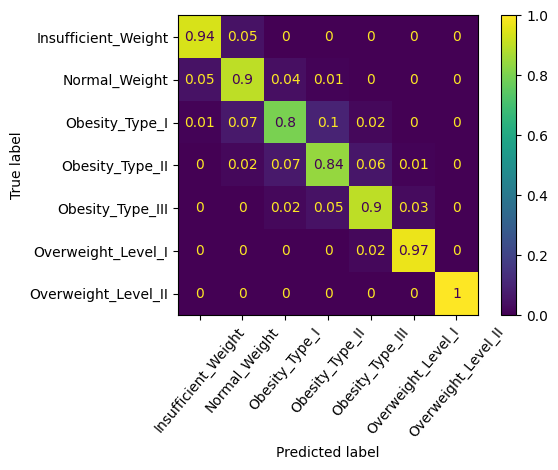

In [126]:
weights = {
           "lgb_":0,
           "xb_":1,
           "CBC_":0}
tmp = oof_list.copy()
for k,v in d_to.items():
    tmp[f"{k}"] = (weights['lgb_']*tmp[f"lgb_{k}"]+
              weights['xb_']*tmp[f"xb_{k}"]+
              weights['CBC_']*tmp[f"CBC_{k}"])    
tmp['pred'] = tmp[d_to.keys()].idxmax(axis = 1)
tmp['label'] = y.map(d)
print("Target baseline:  0.9165244035894069")
print(f"Ensemble Accuracy Score: {accuracy_score(tmp['label'],tmp['pred'])}")
    
cm = confusion_matrix(y_true = tmp['label'].map(d_to),
                      y_pred = tmp['pred'].map(d_to),
                     normalize='true')

cm = cm.round(2)
plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = d_to.keys())
disp.plot(xticks_rotation=50)
plt.tight_layout()
plt.show()

1,9,2
Target baseline:  0.9165244035894069
Ensemble Accuracy Score: 0.9169621361348216

### Submission

In [127]:
# test_predictions = np.argmax(test_predictions,axis=1)
for k,v in d_to.items():
    predict_list[f"{k}"] = (weights['lgb_']*predict_list[f"lgb_{k}"]+
              weights['xb_']*predict_list[f"xb_{k}"]+
              weights['CBC_']*predict_list[f"CBC_{k}"]) 

final_pred = predict_list[d_to.keys()].idxmax(axis = 1)

In [128]:
final_pred

0            Obesity_Type_II
1         Overweight_Level_I
2           Obesity_Type_III
3             Obesity_Type_I
4           Obesity_Type_III
                ...         
13835    Overweight_Level_II
13836          Normal_Weight
13837    Insufficient_Weight
13838          Normal_Weight
13839        Obesity_Type_II
Length: 13840, dtype: object

In [129]:
# res = np.mean(predictions_x_test, axis=0)
ids['NObeyesdad']=pd.Series(final_pred)
# ids['NObeyesdad'] = ids['NObeyesdad'].map(d)
ids.to_csv('submission.csv', index=False)

In [131]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[('lgb', lgb), ('xb', xb), ('CBC', CBC)], 
                              voting='soft')

voting_clf.fit(x, y)

VotingClassifier(estimators=[('lgb',
                              LGBMClassifier(boost_from_average=True,
                                             colsample_bytree=0.7044144019235328,
                                             device='gpu',
                                             gamma=0.01852179446061397,
                                             learning_rate=0.03183892953130785,
                                             max_depth=4,
                                             metric='multi_logloss',
                                             min_child_weight=3,
                                             n_estimators=800, num_class=7,
                                             objective='multiclass',
                                             random_state=42,
                                             reg_alpha=0.7936977033574206,
                                             reg_lambda=0.22...
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=23,
                                            max_leaves=None,
                                            min_child_weight=22, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=664, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softmax', ...)),
                             ('CBC',
                              <catboost.core.CatBoostClassifier object at 0x7cfb018caad0>)],
                 voting='soft')

In [132]:
ids['NObeyesdad'] = voting_clf.predict(test)
ids['NObeyesdad'] = ids['NObeyesdad'].map(d)
ids.to_csv('submission.csv', index=False)

In [133]:
!head submission.csv

id,NObeyesdad
20758,Obesity_Type_II
20759,Overweight_Level_I
20760,Obesity_Type_III
20761,Obesity_Type_I
20762,Obesity_Type_III
20763,Insufficient_Weight
20764,Insufficient_Weight
20765,Normal_Weight
20766,Overweight_Level_II
